In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.gridspec as gridspec


In [16]:
DRIVE_PATH = "/Users/hanlin/Google Drive/CS+/Data/"
def full_path(filename):
    return DRIVE_PATH + filename

In [17]:
#Necessary to get election data for the comp_gmander_score func.
df2 = gpd.read_file(full_path('NCabs_VTD'))
election_data = df2.loc[:, ['VTD_num', "EL16G_PR_D", 'EL16G_PR_R', 'EL16G_PR_T']]

In [18]:
def comp_gmander_score(orig_filepath, pk_pct, rank_num):      
    orig = pd.read_csv(orig_filepath, sep='\t', header=None)
    orig["sample_num"] = -1

    compliant = pd.read_csv(full_path("ensembles_main_rank_" + str(rank_num) + "_compliantVerbose.txt"), sep='\t', header=None)
    compliant.rename(columns={0:"sample_num", 1:"is_compliant"}, inplace=True)
    #Grab a list of compliant numbers
    compliant_nums = compliant[compliant.is_compliant==1].sample_num.tolist()

    #Takes about 5 seconds
    #Iterate through all the compliant samples and read in their data
    pd_lists = []
    for sample_num in compliant_nums:
        filepath = full_path("ensembles_main_rank_" + str(rank_num) 
                             + "_districtingMaps/districtingMap") + str(sample_num) + ".txt"
        new = pd.read_csv(filepath, sep='\t', header=None)
        new["sample_num"] = sample_num
        pd_lists.append(new)
    #Add original districting as a sample
    pd_lists.append(orig)

    final = pd.concat(pd_lists)
    final.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)

    #Join with election data
    final = final.merge(election_data, how='left', on="VTD_num")

    #Group at district level
    grouped = final.groupby(["sample_num", "district"]).sum()

    #Grouped at the district level, calculate district-level stats like dem prop and rep prop
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]
    grouped['dem_win'] = 0
    grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
    grouped.drop(columns=['EL16G_PR_D', 'EL16G_PR_R', 'VTD_num'], inplace=True)

    flattened = grouped.reset_index()

    #Add district-level stats to each VTD
    final2 = final.merge(flattened, how="left", left_on=['sample_num', 'district'], right_on=['sample_num', 'district'])

    #The district_level data for original districting
    orig_dst_lvl = final2.loc[final2.sample_num==-1]
    comp_dst_lvl = final2.loc[final2.sample_num!=-1]

    #Add original districting data to each comparator VTD entry — for easy calculation of differences between comparator
    final3 = comp_dst_lvl.merge(orig_dst_lvl, how="left", left_on='VTD_num', right_on='VTD_num', suffixes=('', '_orig'))

    #these formulas come from Fig. 2 of Warrington's Packed Vtrs Cracked Vtrs
    final3['dem_cracked'] = 0
    final3.loc[(final3.dem_prop > final3.rep_prop) & (final3.dem_prop_orig < final3.rep_prop_orig), 'dem_cracked'] = 1
    final3['rep_cracked'] = 0
    final3.loc[(final3.rep_prop > final3.dem_prop) & (final3.rep_prop_orig < final3.dem_prop_orig), 'rep_cracked'] = 1

    final3['dem_packed'] = 0
    final3.loc[((final3.dem_prop_orig - final3.dem_prop) > pk_pct) & (final3.dem_prop > final3.rep_prop), 'dem_packed'] = 1
    final3['rep_packed'] = 0
    final3.loc[((final3.rep_prop_orig - final3.rep_prop) > pk_pct) & (final3.rep_prop > final3.dem_prop), 'rep_packed'] = 1

    final3['dem_crk_ppl'] = final3.dem_cracked * final3.EL16G_PR_D
    final3['dem_pk_ppl'] = final3.dem_packed * final3.EL16G_PR_D
    final3['rep_crk_ppl'] = final3.rep_cracked * final3.EL16G_PR_R
    final3['rep_pk_ppl'] = final3.rep_packed * final3.EL16G_PR_R

    final3['dem_gmandered'] = final3.dem_crk_ppl + final3.dem_pk_ppl
    final3['rep_gmandered'] = final3.rep_crk_ppl + final3.rep_pk_ppl
    final3['tot_gmandered'] = final3.dem_gmandered + final3.rep_gmandered

    results = final3[['sample_num', 'dem_gmandered', 'rep_gmandered', 'tot_gmandered']].groupby("sample_num").sum()
    results = results.sort_values(by="tot_gmandered").reset_index()
    least_gmandered = results.iloc[0]['sample_num']
    most_gmandered = results.iloc[-1]['sample_num']
    print("avg_tot_gmandered", results.tot_gmandered.mean())
    print("max_tot_gmandered", max(results.tot_gmandered))
    print("min_tot_gmandered", min(results.tot_gmandered))


    def plot_sample_num(sample_num):
        districts = final2.loc[final2.sample_num==sample_num].merge(df2, on='VTD_num', how='left')
        districts = gpd.GeoDataFrame(districts)
        districts.plot(figsize=(15,15),
                   column="rep_prop", cmap="bwr", legend=True, vmin=0, vmax=1)
        plt.title("Rep Vote Percentage Per District")

    #plot_sample_num(least_gmandered)
    #plot_sample_num(most_gmandered)
    
    return final3

In [19]:
def generate_dist_borders(orig_filepath):
    orig = pd.read_csv(orig_filepath, sep='\t', header=None).rename(columns={0:'VTD_num',1:'district'})
    merged = gpd.GeoDataFrame(orig.merge(df2, on='VTD_num'))
    districts = merged[['geometry', 'district']].dissolve(by='district')
    return districts

In [20]:
def generate_heat_maps(orig_filepath, comp_rank_num):

    test = comp_gmander_score(orig_filepath, 0.05, comp_rank_num)
    grouped = test.groupby('VTD_num').sum()
    total_comps = grouped.iloc[0]['sample_num_orig'] * -1
    grouped['pct_dem_crk'] = grouped.dem_cracked/total_comps
    grouped['pct_dem_pk'] = grouped.dem_packed/total_comps
    grouped['pct_rep_crk'] = grouped.rep_cracked/total_comps
    grouped['pct_rep_pk'] = grouped.rep_packed/total_comps
    #Merge with df2, which contains shapefiles
    gdf = gpd.GeoDataFrame(grouped.merge(df2, on="VTD_num"))
    #Read district shapefiles
    districts = generate_dist_borders(orig_filepath)
    
    base = gdf.plot(column='pct_dem_crk', cmap='Reds', legend=True,  figsize=(18, 16), vmin=0, vmax=1, legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=1, facecolor='none')
    plt.title('Dem Crack')
    #gdf.plot(ax=base, column='pct_dem_pk', cmap='Blues', linewidth=1, legend=True, alpha=0.5)

    base = gdf.plot(column='pct_dem_pk', cmap="Blues", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Dem Pack')

    base = gdf.plot(column='pct_rep_crk', cmap="Reds", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Rep Crack')

    base = gdf.plot(column='pct_rep_pk', cmap="Blues", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Rep Pack')

### The Real Deal, creating polished heatmaps

In [52]:
def heatmap2(orig_file_path, districts, party):

    #Using 2016 districting and comparing against the suite generated from judges
    test = comp_gmander_score(orig_file_path, 0.05, 0)

    #Group by VTD_num to get probability statistics
    grouped = test.groupby('VTD_num').sum()
    total_comps = grouped.iloc[0]['sample_num_orig'] * -1
    grouped['pct_dem_crk'] = grouped.dem_cracked/total_comps
    grouped['pct_dem_pk'] = grouped.dem_packed/total_comps
    grouped['pct_rep_crk'] = grouped.rep_cracked/total_comps
    grouped['pct_rep_pk'] = grouped.rep_packed/total_comps
    #Merge with df2, which contains shapefiles
    gdf = gpd.GeoDataFrame(grouped.merge(df2, on="VTD_num"))
    #Read district shapefiles
    plt.rcParams['hatch.color'] = 'white'
    
    if party =='dem':

        dem_crk = gdf[gdf.pct_dem_crk != 0]
        dem_pk = gdf[gdf.pct_dem_pk != 0]

        base1 = dem_crk.plot(column='pct_dem_crk', cmap='Oranges', legend=True,  figsize=(18, 16), 
                             vmin=0, vmax=1, legend_kwds={'shrink': 0.3, 'label':'Percent Dem Cracked', 'orientation':'vertical','pad':0}, hatch='.')
        base2 = dem_pk.plot(ax=base1, column='pct_dem_pk', cmap='Purples', legend=True,  figsize=(18, 16), vmin=0, vmax=1, 
                            legend_kwds={'shrink': 0.3, 'label':'Percent Dem Packed', 'orientation':'vertical', 'pad':0})
        districts.plot(ax=base2, edgecolor='black', linewidth=1, facecolor='none')
        plt.title('Percent of Democrats Packed and Cracked Relative to 1055 Comparators')
        plt.axis('off')
    else:
        rep_crk = gdf[gdf.pct_rep_crk != 0]
        rep_pk = gdf[gdf.pct_rep_pk != 0]

        base1 = rep_crk.plot(column='pct_rep_crk', cmap='Oranges', legend=True,  figsize=(18, 16), 
                             vmin=0, vmax=1, legend_kwds={'shrink': 0.3, 'label':'Percent Rep Cracked', 'orientation':'vertical','pad':0}, hatch='.')
        base2 = rep_pk.plot(ax=base1, column='pct_rep_pk', cmap='Purples', legend=True,  figsize=(18, 16), vmin=0, vmax=1, 
                            legend_kwds={'shrink': 0.3, 'label':'Percent Rep Packed', 'orientation':'vertical', 'pad':0})
        districts.plot(ax=base2, edgecolor='black', linewidth=1, facecolor='none')
        plt.title('Percent of Republicans Packed and Cracked Relative to 1055 Comparators')
        plt.axis('off')


In [33]:
districts = generate_dist_borders('overnight.txt')

In [54]:
orig_districts = gpd.read_file(full_path('2016_NC_shapefiles_updated'))

avg_tot_gmandered 1151027.4312796209
max_tot_gmandered 1706437
min_tot_gmandered 557238


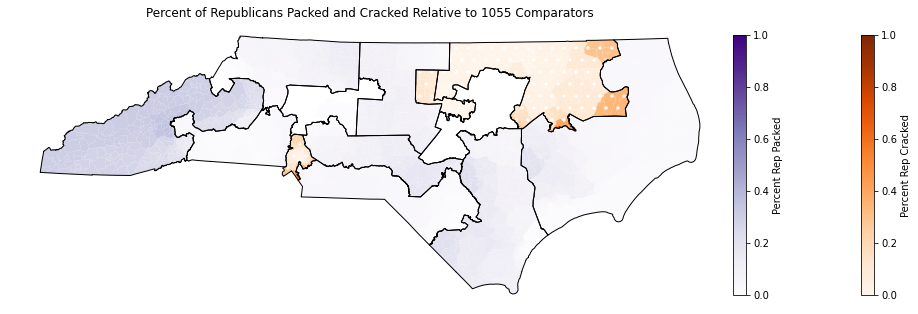

In [55]:
heatmap2(full_path('code_data_NC_NCAbs_2016.txt'), orig_districts, 'rep')

### just generating overall district maps

In [45]:
bleh = pd.read_csv(full_path('acr_VTD.txt'), sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
merged = bleh.merge(df2, on='VTD_num')

(83408.25889999681, 976394.0624999974, -15041.311504998801, 333963.37100500014)

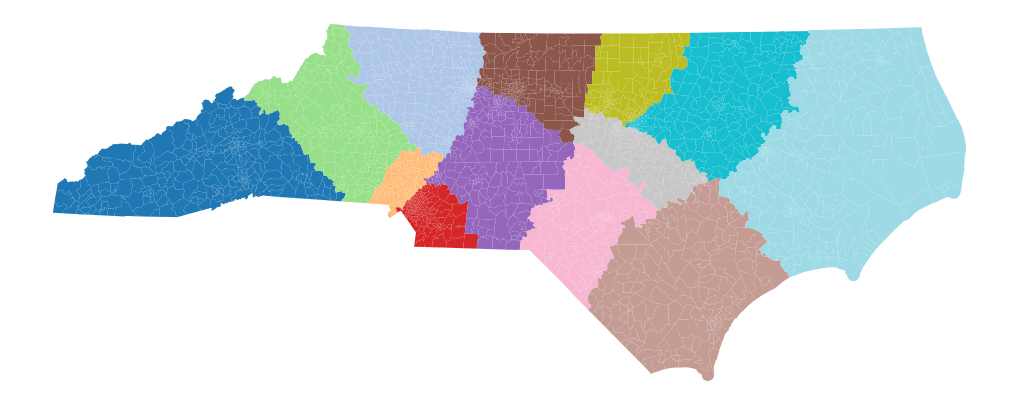

In [46]:
gpd.GeoDataFrame(merged).plot(column='district', figsize=(18,16), cmap='tab20')
plt.axis('off')